# 중고차 가격 예측

In [ ]:
!pip install pycaret==2.1.2

In [ ]:
!pip install scikit-learn==0.23 # 반드시 Scikit-learn 버전을 맞춰줘야 합니다!

In [ ]:
!pip install scipy==1.5.3 # 반드시 Scipy 버전을 맞춰줘야 합니다! 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pycaret.regression import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score

from catboost import CatBoostRegressor

## Pycaret (BMW)

In [ ]:
bmw = pd.read_csv('/content/drive/MyDrive/used_car/bmw.csv', encoding='utf-8')

In [ ]:
bmw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10781 entries, 0 to 10780
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         10781 non-null  object 
 1   year          10781 non-null  int64  
 2   price         10781 non-null  int64  
 3   transmission  10781 non-null  object 
 4   mileage       10781 non-null  int64  
 5   fuelType      10781 non-null  object 
 6   tax           10781 non-null  int64  
 7   mpg           10781 non-null  float64
 8   engineSize    10781 non-null  float64
dtypes: float64(2), int64(4), object(3)
memory usage: 758.2+ KB


In [ ]:
# DataFrame의 결측치, 이상치 제거 및 대체

# engineSize 0(=결측치) i3모델에만 발생하고 있어 실제 엔진사이즈 0.6으로 변경
bmw.loc[(bmw['model']=='i3'), ['engineSize']] = 0.6
bmw['tax'] = bmw['tax'].replace(to_replace=0, value=bmw['tax'].median())

bmw['model'] = bmw[['model']].apply(lambda x: x.str.strip())
bmw.loc[(bmw['fuelType']=='Hybrid') & (bmw['model']=='i3'), ['mpg']] = 111
bmw.loc[(bmw['fuelType']=='Electric') & (bmw['model']=='i3'), ['mpg']] = 118
bmw.loc[(bmw['fuelType']=='Other') & (bmw['model']=='i3'), ['mpg']] = 118
bmw['engineSize'] = bmw[['engineSize']].replace(0,bmw['engineSize'].mode()[0])
bmw['tax'] = bmw[['tax']].replace(0,bmw[['tax']].median())

In [ ]:
# tax 범주화

bmw['tax_cut'] = pd.cut(bmw.tax,bins=[0,20,30,130,155,170,210,250,275,315,340,600],
                       labels=['A','B','C','D','E','F','G','H','I','J','K'])

In [ ]:
# 엔진 크기 범주화

bmw['engineSize'] =  bmw['engineSize']//1

In [ ]:
# 모델별 성능 확인

model = setup(data=bmw, 
              target='price', 
              train_size=0.7,
              session_id=123,
              categorical_features = ['year'] # year 열은 실제 연도가 아닌 연식으로 자동으로 모델 셋업 시 강제로 Categorical_feature로 반영
              )

 
Setup Succesfully Completed.


,Description,Value
0,session_id,123
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(10781, 10)"
4,Missing Values,False
5,Numeric Features,4
6,Categorical Features,5
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [ ]:
# Set-up을 바탕으로 각 모델별 성능비교(Hyper parameter defalut 비교하는 것으로 추정 )

top_3_models = compare_models(sort='RMSE', fold=10, n_select=3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,CatBoost Regressor,1522.7868,5518949.6434,2338.0717,0.9577,0.1183,0.0740,1.4085
1,Light Gradient Boosting Machine,1669.2801,6788256.7837,2595.4119,0.9479,0.1183,0.0808,0.0969
2,Extra Trees Regressor,1650.1426,7134279.8798,2657.7005,0.9449,0.1126,0.0779,1.1449
3,Random Forest,1669.0292,7207304.4689,2674.1877,0.9448,0.1201,0.0819,1.2461
4,Gradient Boosting Regressor,2286.6978,11009394.0653,3309.0082,0.9154,0.1577,0.1161,0.9246
5,Extreme Gradient Boosting,2301.6655,11170871.5927,3334.3631,0.9141,0.1593,0.1172,0.4646
6,Decision Tree,2156.6657,12654452.0385,3546.6520,0.9027,0.1566,0.1051,0.0487
7,Linear Regression,2456.4497,12737814.5184,3554.9189,0.9020,0.1988,0.1227,0.0330
8,Bayesian Ridge,2458.7856,12774066.6205,3559.7113,0.9017,0.2213,0.1227,0.0605
9,Ridge Regression,2468.7026,12846745.9091,3569.6232,0.9012,0.1993,0.1236,0.0085


In [ ]:
# 모델 성능 비교 Top3 출력

top_3_models

 LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
 ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     max_samples=None, min_impurity_decrease=0.0,
                     min_impurity_split=None, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=100, n_jobs=-1, oob_score=False,
                     random_state=123, verbose=0, warm_start=False)]

In [ ]:
# Top 1(Catboost) 모델의 출력 값이 다른 모델과 다르게 주소값만 출력하기 때문에 기존 예제처럼 일부 기능을 사용하지 못하기 때문에 내부 parameter 별도 확인을 위한 dir 메소드 사용 

# dir(top_3_models[0])

In [ ]:
evaluate_model(top_3_models[1]) # 설정된 Hyper-params의 값, AUC/Confusion matrix 등 성능 지표, Feature importance 등을 바로 확인할 수 있음

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

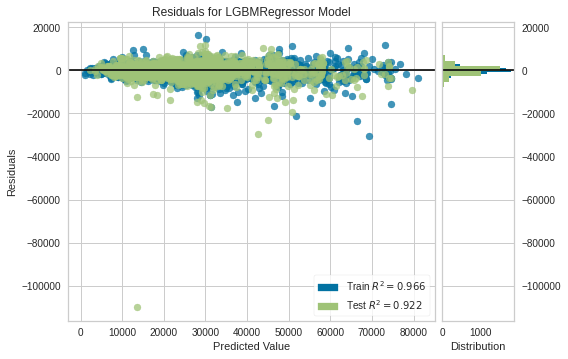

In [ ]:
# Train, Test Residuals

lgbm = top_3_models[1]
plot_model(lgbm)

In [ ]:
# Catboost로 예측한 모델 성능 확인

predict_bmw = predict_model(top_3_models[0])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,1555.2536,8.974858e+06,2995.8067,0.9312,0.1087,0.0725


In [ ]:
# Catboost 모델 생성 + Hyper parameter 튜닝

catboost = create_model('catboost')
tuned_catboost_pycaret = tune_model(catboost, n_iter = 100, optimize = 'RMSE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1575.1591,6056096.1620,2460.9137,0.9587,0.1489,0.0793
1,1434.3685,4085980.6797,2021.3809,0.9653,0.1081,0.0737
2,1531.8070,6946305.3979,2635.5845,0.9490,0.1099,0.0722
3,1603.2964,7184609.9093,2680.4123,0.9511,0.0996,0.0702
4,1547.1979,5420460.1340,2328.1882,0.9598,0.1041,0.0725
5,1360.0344,3874758.2007,1968.4406,0.9694,0.1123,0.0751
6,1573.9338,6950553.0911,2636.3902,0.9458,0.1223,0.0815
7,1451.4005,5392564.0563,2322.1895,0.9566,0.0990,0.0685
8,1500.3140,4515215.4827,2124.9036,0.9581,0.1252,0.0735
9,1502.7670,4969613.2160,2229.2629,0.9619,0.1006,0.0694


In [ ]:
# 튜닝된 Hyper parameter 확인

tuned_catboost_pycaret.get_params()

{'border_count': 200,
 'depth': 7,
 'iterations': 500,
 'l2_leaf_reg': 3,
 'learning_rate': 0.1,
 'loss_function': 'RMSE',
 'random_state': 123,
 'silent': True}

In [ ]:
# Hyper parameter 가 튜닝된 상태의 모델의 예측 확인

predict_model(tuned_catboost_pycaret)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,1545.5344,8.869070e+06,2978.0984,0.932,0.1192,0.0728


,mileage,tax,mpg,engineSize,model_1 Series,model_2 Series,model_3 Series,model_4 Series,model_5 Series,model_6 Series,model_7 Series,model_8 Series,model_M2,model_M3,model_M4,model_M5,model_M6,model_X1,model_X2,model_X3,model_X4,model_X5,model_X6,model_X7,model_Z3,model_Z4,model_i3,model_i8,year_1996.0,year_1997.0,year_1998.0,year_1999.0,year_2000.0,year_2001.0,year_2002.0,year_2003.0,year_2004.0,year_2005.0,year_2006.0,year_2007.0,year_2008.0,year_2009.0,year_2010.0,year_2011.0,year_2012.0,year_2013.0,year_2014.0,year_2015.0,year_2016.0,year_2017.0,year_2018.0,year_2019.0,year_2020.0,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol,tax_cut_A,tax_cut_B,tax_cut_C,tax_cut_D,tax_cut_E,tax_cut_F,tax_cut_G,tax_cut_H,tax_cut_I,tax_cut_J,tax_cut_K,price,Label
0,20153.0,145.0,55.4,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19498.0,19156.0820
1,66243.0,145.0,68.9,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12899.0,13061.8075
2,25.0,145.0,34.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45898.0,43760.1253
3,5.0,145.0,42.8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29990.0,27512.9297
4,45580.0,125.0,61.4,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16000.0,15704.1513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3230,68000.0,325.0,34.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,13190.0,16000.3531
3231,10164.0,145.0,68.9,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18480.0,18831.3561
3232,9957.0,145.0,49.6,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21999.0,22070.2512
3233,70620.0,125.0,60.1,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12500.0,12

## ML Model Compare (BMW)

### 전처리

In [ ]:
bmw_new = pd.read_csv('/content/drive/MyDrive/used_car/bmw.csv', encoding='utf-8')

In [ ]:
bmw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10781 entries, 0 to 10780
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   model         10781 non-null  object  
 1   year          10781 non-null  int64   
 2   price         10781 non-null  int64   
 3   transmission  10781 non-null  object  
 4   mileage       10781 non-null  int64   
 5   fuelType      10781 non-null  object  
 6   tax           10781 non-null  int64   
 7   mpg           10781 non-null  float64 
 8   engineSize    10781 non-null  float64 
 9   tax_cut       10781 non-null  category
dtypes: category(1), float64(2), int64(4), object(3)
memory usage: 769.1+ KB


In [ ]:
# DataFrame의 결측치, 이상치 제거 및 대체

bmw_new.loc[(bmw_new['model']=='i3'), ['engineSize']] = 0.6 #engineSize 0인건 i3모델뿐이어서 실제값인 0.6으로 변경
bmw_new['tax'] = bmw_new['tax'].replace(to_replace=0, value=bmw_new['tax'].median())

bmw_new['model'] = bmw_new[['model']].apply(lambda x: x.str.strip())
bmw_new.loc[(bmw_new['fuelType']=='Hybrid') & (bmw_new['model']=='i3'), ['mpg']] = 111
bmw_new.loc[(bmw_new['fuelType']=='Electric') & (bmw_new['model']=='i3'), ['mpg']] = 118
bmw_new.loc[(bmw_new['fuelType']=='Other') & (bmw_new['model']=='i3'), ['mpg']] = 118
bmw_new['engineSize'] = bmw_new[['engineSize']].replace(0,bmw_new['engineSize'].mode()[0])
bmw_new['tax'] = bmw_new[['tax']].replace(0,bmw_new[['tax']].median())

In [ ]:
# tax 범주화

bmw_new['tax_cut'] = pd.cut(bmw_new.tax,bins=[0,20,30,130,155,170,210,250,275,315,340,600],
                       labels=['A','B','C','D','E','F','G','H','I','J','K'])

In [ ]:
# 엔진 크기 범주화

bmw_new['engineSize'] =  bmw_new['engineSize']//1

In [ ]:
x = bmw_new.drop(['price'],axis=1)
y = bmw_new['price']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

In [ ]:
# 연속형 변수 열 입력

numeric_features = ['year','mileage','tax','mpg']
numeric_transformer = StandardScaler() # cf) RobustScaler

# 범주형 변수 열 입력

categorical_features = ['model','transmission','fuelType','engineSize']
categorical_transformer = OneHotEncoder(categories='auto', handle_unknown='ignore') # 범주형 데이터가 x_train, x_test에 고르게 들어가지 않는 경우 pass 하기 위해 handel_unknown param ='ignore' 로 설정

preprocessor = ColumnTransformer(
    transformers=[ # List of (name, transformer, column(s))
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [ ]:
preprocessor_pipe = Pipeline(steps=[('preprocessor', preprocessor)]) # 스텝은 전처리 까지만

In [ ]:
# StandardScaler, One-Hot Encoder 적용

preprocessor_pipe.fit(x_train, x_test)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  ['year', 'mileage', 'tax',
                                                   'mpg']),
                                                 ('cat',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                   

In [ ]:
x_train_transformed = preprocessor_pipe.transform(x_train)
x_test_transformed = preprocessor_pipe.transform(x_test)

### CatBoost Regressor

In [ ]:
# 깡통모델 예측성능 확인

test_model = CatBoostRegressor()
test_model = test_model.fit(x_train_transformed, y_train, verbose=False)

In [ ]:
# Model Predict

predict_test_y = test_model.predict(x_test_transformed)

In [ ]:
# Model Score

print(f'RMSE : {(mean_squared_error(y_test, predict_test_y)**0.5):.2f}')
print(f'R2 score :{(r2_score(y_test, predict_test_y)*100):.2f} %')

RMSE : 3033.03
R2 score :92.97 %


### GridSearch

In [ ]:
# Pycalot HPO
# {'border_count': 200,
#  'depth': 7,
#  'iterations': 500,
#  'l2_leaf_reg': 3,
#  'learning_rate': 0.1,
#  'loss_function': 'RMSE',
#  'random_state': 123,
#  'silent': True}

model_catboostReg = CatBoostRegressor()
param_grid_catboost = {
                        'learning_rate': [0.01, 0.05, 0.1],
                        'iterations': [100, 300, 500],
                        'depth': [6, 8, 10], #In most cases, the optimal depth ranges from 4 to 10. Values in the range from 6 to 10 are recommended.
                        'l2_leaf_reg': [1, 3, 5, 7, 10]
                       }

grid_search_result = model_catboostReg.grid_search(param_grid_catboost, 
                                       X=x_train_transformed, 
                                       y=y_train, 
                                       plot=True)

In [ ]:
# Tuned Hyper-params get

grid_search_result.get('params')

{'depth': 6, 'iterations': 500, 'l2_leaf_reg': 3, 'learning_rate': 0.1}

In [ ]:
# Tuned Hyper-params in Catboost model

tuned_catboost = CatBoostRegressor(depth=6, l2_leaf_reg=3, iterations=500, learning_rate=0.1)

In [ ]:
tuned_catboost.fit(x_train_transformed, y_train, verbose=False)

In [ ]:
# Model Predict

predict_y = tuned_catboost.predict(x_test_transformed)

In [ ]:
# Model Score

print(f'RMSE : {(mean_squared_error(y_test, predict_y)**0.5):.2f}')
print(f'R2 score :{(r2_score(y_test, predict_y)*100):.2f} %')

RMSE : 3046.60
R2 score :92.90 %
